In [1]:
import pandas as pd 
import matplotlib 
from matplotlib import pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Multivariate Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import GridSearchCV
import joblib 

In [2]:
df = pd.read_csv('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/data/csv_result-WISDM_ar_v1.csv', na_values='?')
dfx = pd.read_csv('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/data/csv_result-WISDM_ar_v1.csv', na_values='?')
df = df.rename(columns = {'class{':'class'})
dfx = dfx.rename(columns = {'class{':'class'})

In [3]:
y = df['class']
X = dfx.drop(columns = ['id','UNIQUE_ID','class'])

In [4]:
id = np.unique(df['user'])
user = df['user']

# EDA

In [5]:
classes, counts = np.unique(y,return_counts=True)
print(classes, counts)
print('balance:',np.max(counts/len(y)))
print('Data is inblanced, there are much more walking and jogging classes than any other')

['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking'] [ 528 1625  306  246  632 2081]
balance: 0.38409007013658175
Data is inblanced, there are much more walking and jogging classes than any other


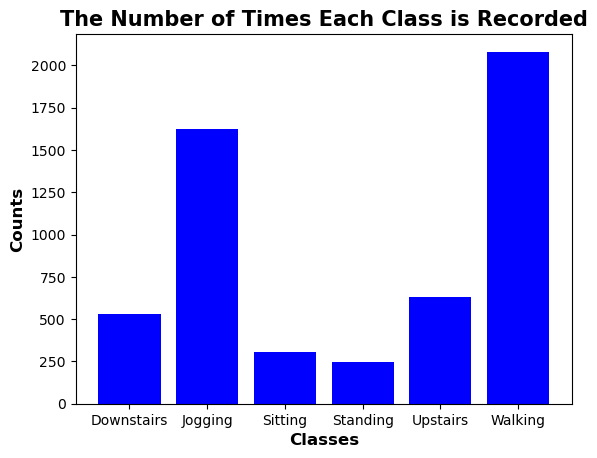

In [6]:
#Bar plot with 5 more important features 
plt.bar(classes, counts, color='blue')
plt.xlabel('Classes', weight='bold', fontsize=12)
plt.ylabel('Counts', weight = 'bold', fontsize=12)
plt.title('The Number of Times Each Class is Recorded', weight = 'bold', fontsize=15)
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/BarPlotClassRecords.png", dpi=300,bbox_inches='tight')
plt.show()

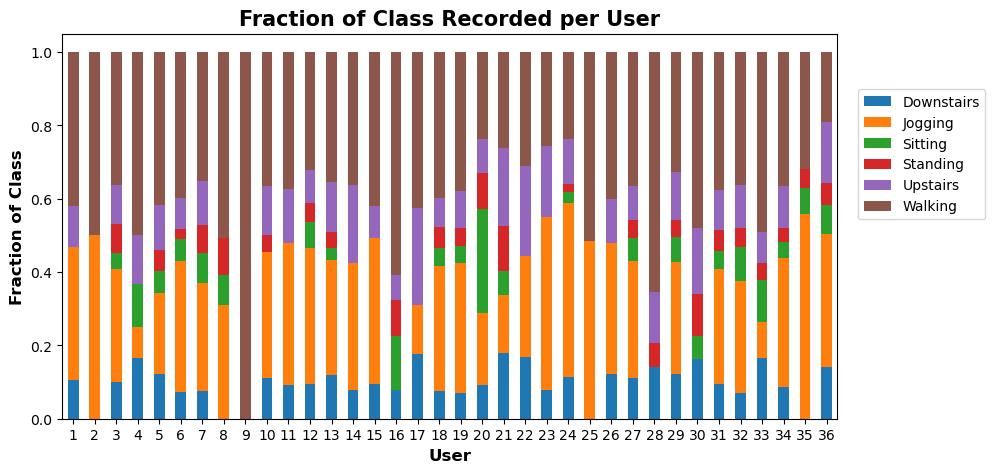

In [7]:
count_matrix = df.groupby(['user', 'class']).size().unstack()
# print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,5))
plt.ylabel('Fraction of Class', weight = 'bold',fontsize=12)
plt.xlabel('User', weight='bold',fontsize=12)
plt.xticks(rotation=0)
plt.title('Fraction of Class Recorded per User', weight='bold',fontsize=15)
plt.legend(bbox_to_anchor = (1.2,0.5), loc = 'lower right')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/ClassRecordsFraction.png", dpi=300,bbox_inches='tight')
plt.show()

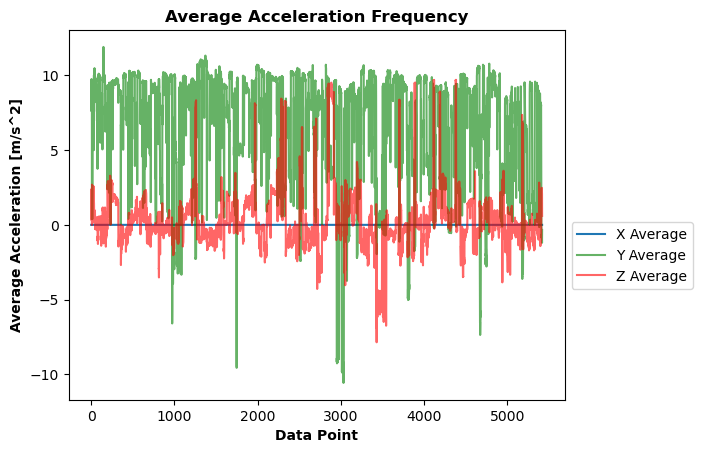

In [8]:
# Plot XYZ Averages 
plt.plot(df['id'],df['XAVG'], label = 'X Average')
plt.plot(df['id'],df['YAVG'], label = 'Y Average',color='green',alpha=0.6)
plt.plot(df['id'],df['ZAVG'], label = 'Z Average',color='red', alpha =0.6)
plt.legend(bbox_to_anchor = (1,0.5))
plt.ylabel('Average Acceleration [m/s^2]', weight='bold')
plt.title('Average Acceleration Frequency', weight='bold')
plt.xlabel('Data Point', weight='bold')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/XYZAvgAcceleration.png", dpi=300,bbox_inches='tight')
plt.show()

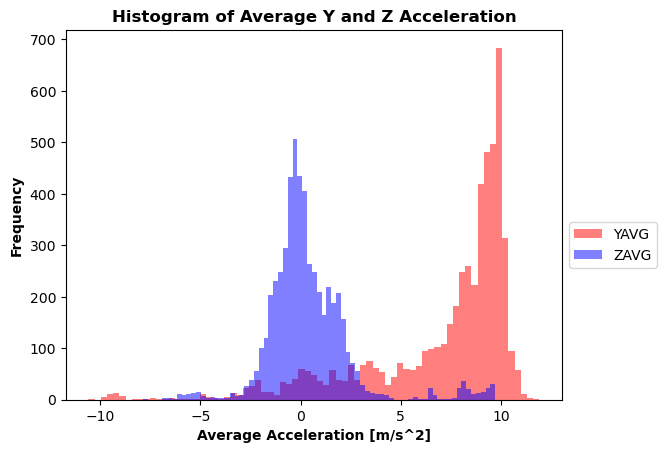

In [9]:
# Histogram of each XYZ Average 

#Y Average
df['YAVG'].plot.hist(bins = int(np.sqrt(df.shape[0])), color = 'red', alpha=0.5)

#Z Average 
df['ZAVG'].plot.hist(bins = int(np.sqrt(df.shape[0])), color='blue', alpha = 0.5)
plt.xlabel('Average Acceleration [m/s^2]', weight='bold')
plt.title('Histogram of Average Y and Z Acceleration', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.legend(bbox_to_anchor = (1,0.5))
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/HistogramYZAcc.png", dpi=300,bbox_inches='tight')
plt.show()

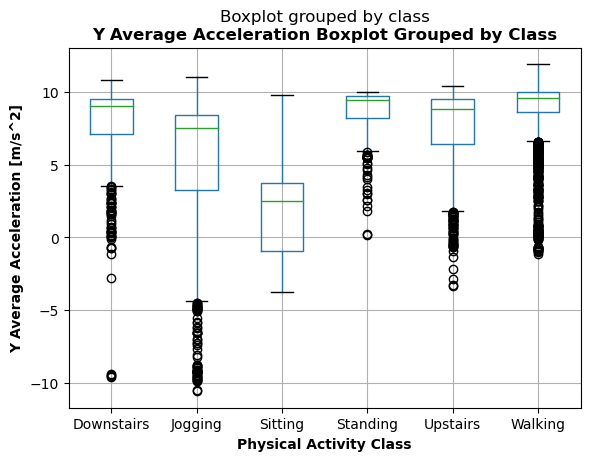

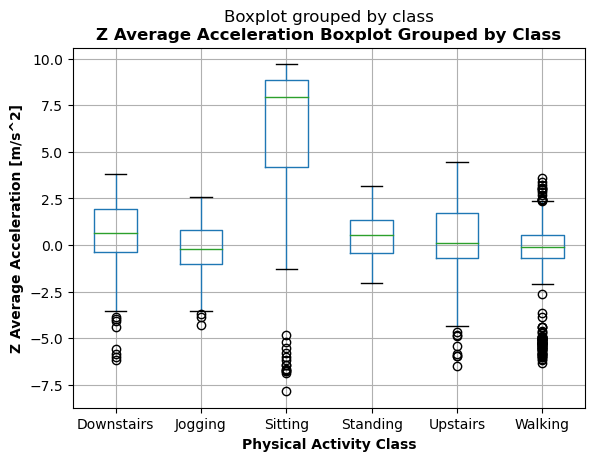

In [10]:
df[['YAVG','class']].boxplot(by='class')
plt.xlabel('Physical Activity Class',weight='bold')
plt.ylabel('Y Average Acceleration [m/s^2]',weight='bold')
plt.title('Y Average Acceleration Boxplot Grouped by Class', weight='bold')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/BoxPlotYAVG.png", dpi=300,bbox_inches='tight')
plt.show()

df[['ZAVG','class']].boxplot(by='class')
plt.xlabel('Physical Activity Class',weight='bold')
plt.ylabel('Z Average Acceleration [m/s^2]',weight='bold')
plt.title('Z Average Acceleration Boxplot Grouped by Class', weight='bold')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/BoxPlotZAVG.png", dpi=300,bbox_inches='tight')
plt.show()

# Cross-Validation

In [11]:
np.random.seed(42)
def ML_pipeline(X,y,groups,n_folds, ML_algo, param_grid):
    # list to be returned
    best_models = []
    acc_list = []
    prec_list = []
    f1beta_list = []
    recall_list = []
    model_dict = {}
    random_states = list(range(1,11))
    for i,state in enumerate(random_states):
        print('randoms state '+str(i+1))
        # Split the Data
        splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=state) #group based splitting 
        for i_other,i_test in splitter.split(X, y, groups): #don't use test_train_split 
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
        
        # splitter for _other
        kf = GroupKFold(n_splits=n_folds)
        for train_index, val_index in kf.split(X_other, y_other, groups_other):
 
            X_train = X_other.iloc[train_index]
            y_train = y_other.iloc[train_index]
            X_val = X_other.iloc[val_index]
            y_val = y_other.iloc[val_index]
    
        #Preprocess the data 
        cols = X_train.columns
        std_ftrs = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
           'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
           'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
           'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
           'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT']
    
        # collect all the encoders
        preprocessor = ColumnTransformer(
            transformers=[
                ('std', StandardScaler(), std_ftrs)])
        
        clf = Pipeline(steps=[('preprocessor', preprocessor)])
        
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep = clf.transform(X_val)
        X_test_prep = clf.transform(X_test)
        
        #Add back the User column
        train_col = X_train['user']
        val_col = X_val['user']
        test_col = X_test['user']
        
        X_train_prep = np.column_stack((train_col, X_train_prep))
        X_val_prep = np.column_stack((val_col, X_val_prep))
        X_test_prep = np.column_stack((test_col, X_test_prep))
        
        df_test = pd.DataFrame(data=X_test_prep,columns = cols)
        df_train = pd.DataFrame(data=X_train_prep,columns = cols)
        df_val = pd.DataFrame(data=X_val_prep, columns = cols)
    
        # Missing Values Imputation
        imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
        X_impute = imputer.fit_transform(df_train)
        df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)
        df_val_imp = pd.DataFrame(data=imputer.transform(df_val), columns = df_train.columns)
        df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)
    
        # Train Models 
        y_true = y_test
        grid_search = GridSearchCV(ML_algo, param_grid=param_grid, scoring='accuracy', n_jobs=-1,error_score='raise',return_train_score = True)
        grid_search.fit(df_train_imp, y_train)

        bestmodel = grid_search.best_estimator_

        # Predict on the test set using the best model
        y_pred = bestmodel.predict(df_test_imp)
    
        # Calculate Precision, Recall, and F1 Scrore
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average = 'weighted', zero_division=1)
        recall = recall_score(y_true, y_pred, average = 'weighted')
        f1_score = fbeta_score(y_true, y_pred, beta=1, average = 'weighted')
    
        # Append to lists
        f1beta_list.append(f1_score)
        best_models.append(bestmodel)
        acc_list.append(accuracy)
        prec_list.append(precision)
        recall_list.append(recall)
    
    
        print('accuracy', accuracy)
        print('precision',precision)
        print('recall',recall)
        print('f1',f1_score)
        print('best model:', bestmodel)
        
    #Save lists to a dictionary 
    model_dict['Accuracy'] = acc_list
    model_dict['Precision'] = prec_list
    model_dict['Recall'] = recall_list
    model_dict['F1 Beta Score'] = f1beta_list
    model_dict['Y Precitions'] = y_pred
    model_dict['Y Test'] = y_true
    model_dict['X Test'] = df_test_imp
    
    return model_dict, y_pred, y_true, best_models, grid_search #, np.array(feature_names)


# Run Models

In [12]:
# Logistic Regression L2
log_model2 = LogisticRegression()

param_log2 = {
    'penalty': ['l2'], 
    'solver': ['saga'],
    # 'C': [0.001,0.1,1,10,100]
    # 'max_iter': [1000,5000]
    'C': [0.1],
    'max_iter': [1000]
}

log2_dict, y_pred_log2, y_true_log2, best_models_log2, log2_grid = ML_pipeline(X,y,user,5,log_model2, param_log2)



randoms state 1
accuracy 0.7515822784810127
precision 0.7101586268998453
recall 0.7515822784810127
f1 0.7120066926786703
best model: LogisticRegression(C=0.1, max_iter=1000, solver='saga')
randoms state 2
accuracy 0.7852713178294574
precision 0.7532258040624514
recall 0.7852713178294574
f1 0.7358092739579272
best model: LogisticRegression(C=0.1, max_iter=1000, solver='saga')
randoms state 3
accuracy 0.8025531914893617
precision 0.7723289737747829
recall 0.8025531914893617
f1 0.7708300727630943
best model: LogisticRegression(C=0.1, max_iter=1000, solver='saga')
randoms state 4
accuracy 0.6232179226069247
precision 0.5506578268085655
recall 0.6232179226069247
f1 0.5740268634980076
best model: LogisticRegression(C=0.1, max_iter=1000, solver='saga')
randoms state 5
accuracy 0.7742435996896819
precision 0.7525488802612024
recall 0.7742435996896819
f1 0.7231188672376888
best model: LogisticRegression(C=0.1, max_iter=1000, solver='saga')
randoms state 6
accuracy 0.7655763239875389
precision 0

In [13]:
##### Logisitic Regression L2 #####
print('Logistic Regression Precision score mean:', np.mean(log2_dict['Precision']))
print('Logistic Regression score std:', np.std(log2_dict['Precision']))

Logistic Regression Precision score mean: 0.724721478082659
Logistic Regression score std: 0.06745476510447575


In [14]:
print('Logistic Regression Recall score mean:', np.mean(log2_dict['Recall']))
print('Logistic Regression score std:', np.std(log2_dict['Recall']))

Logistic Regression Recall score mean: 0.7587609759537959
Logistic Regression score std: 0.054437456452238485


In [15]:
print('Logistic Regression F1 Beta score mean:', np.mean(log2_dict['F1 Beta Score']))
print('Logistic Regression score std:', np.std(log2_dict['F1 Beta Score']))

Logistic Regression F1 Beta score mean: 0.718211167342035
Logistic Regression score std: 0.05951497720492446


In [16]:
acc_log2_mean = np.mean(log2_dict['Accuracy'])
acc_log2_std =  np.std(log2_dict['Accuracy'])
print('Logistic Regression Accuracy score mean:', np.mean(log2_dict['Accuracy']))
print('Logistic Regression score std:', np.std(log2_dict['Accuracy']))

Logistic Regression Accuracy score mean: 0.7587609759537959
Logistic Regression score std: 0.054437456452238485


In [17]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier()

param_grid_RF = {
              # 'max_depth': [1, 3, 10], # the max_depth should be smaller or equal than the number of features roughly
              # 'max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
              'max_depth': [3, 10], # the max_depth should be smaller or equal than the number of features roughly
              'max_features': [0.5,0.75] 
              } 
rf_dict, y_pred_rf, y_true_rf, best_models_rf, rf_grid = ML_pipeline(X,y,user,5,RF_model, param_grid_RF)


joblib.dump(best_models_rf, '/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_RF.pkl')

randoms state 1
accuracy 0.7958860759493671
precision 0.7939188183430667
recall 0.7958860759493671
f1 0.788041924503424
best model: RandomForestClassifier(max_depth=10, max_features=0.5)
randoms state 2
accuracy 0.7868217054263565
precision 0.7571508444441135
recall 0.7868217054263565
f1 0.7511444426538727
best model: RandomForestClassifier(max_depth=10, max_features=0.5)
randoms state 3
accuracy 0.7497872340425532
precision 0.7552727992730234
recall 0.7497872340425532
f1 0.7481969940825539
best model: RandomForestClassifier(max_depth=10, max_features=0.5)
randoms state 4
accuracy 0.6191446028513238
precision 0.6411392605525509
recall 0.6191446028513238
f1 0.6200375383856722
best model: RandomForestClassifier(max_depth=10, max_features=0.5)
randoms state 5
accuracy 0.7835531419705197
precision 0.7913256406152589
recall 0.7835531419705197
f1 0.7803989833657181
best model: RandomForestClassifier(max_depth=10, max_features=0.75)
randoms state 6
accuracy 0.8006230529595015
precision 0.7879

['/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_RF.pkl']

In [18]:
acc_rf_mean = np.mean(rf_dict['Accuracy'])
acc_rf_std =  np.std(rf_dict['Accuracy'])

print('Random Forest Accuracy score mean:', np.mean(rf_dict['Accuracy']))
print('Random Forest Accuracy Score std:', np.std(rf_dict['Accuracy']))
                       

Random Forest Accuracy score mean: 0.7622097159384513
Random Forest Accuracy Score std: 0.056470392296834475


In [19]:
print('Random Forest Precision score mean:', np.mean(rf_dict['Precision']))
print('Random Forest score std:', np.std(rf_dict['Precision']))

Random Forest Precision score mean: 0.7687760060484922
Random Forest score std: 0.049214102753639674


In [20]:
print('Random Forest Recall score mean:', np.mean(rf_dict['Recall']))
print('Random Forest score std:', np.std(rf_dict['Recall']))

Random Forest Recall score mean: 0.7622097159384513
Random Forest score std: 0.056470392296834475


In [21]:
print('Random Forest F1 Beta score mean:', np.mean(rf_dict['F1 Beta Score']))
print('Random Forest score std:', np.std(rf_dict['F1 Beta Score']))

Random Forest F1 Beta score mean: 0.7484656644511714
Random Forest score std: 0.05444245599751368


In [22]:
# SVC
from sklearn.svm import SVC

SVC_model = SVC(probability=True)
param_grid_svc = {
    # 'C': [1e-1, 1e0, 1e1],
    # 'gamma': [1e-3, 1e-1, 1e1, 1e3]
    'C': [10],
    'gamma':[0.001]
}
svc_dict, y_pred_svc, y_true_svc, best_models_svc, svc_grid = ML_pipeline(X,y,user,5,SVC_model, param_grid_svc)


joblib.dump(best_models_svc, '/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_SVC.pkl')

randoms state 1
accuracy 0.7634493670886076
precision 0.7300670705300341
recall 0.7634493670886076
f1 0.717140886134394
best model: SVC(C=10, gamma=0.001, probability=True)
randoms state 2
accuracy 0.7627906976744186
precision 0.7297224644617025
recall 0.7627906976744186
f1 0.701391258605101
best model: SVC(C=10, gamma=0.001, probability=True)
randoms state 3
accuracy 0.796595744680851
precision 0.7622288634721077
recall 0.796595744680851
f1 0.7533751125710225
best model: SVC(C=10, gamma=0.001, probability=True)
randoms state 4
accuracy 0.5885947046843177
precision 0.5312515606338843
recall 0.5885947046843177
f1 0.5470692285301584
best model: SVC(C=10, gamma=0.001, probability=True)
randoms state 5
accuracy 0.7532971295577967
precision 0.705687511856781
recall 0.7532971295577967
f1 0.6977688974750513
best model: SVC(C=10, gamma=0.001, probability=True)
randoms state 6
accuracy 0.7842679127725857
precision 0.7351773652501818
recall 0.7842679127725857
f1 0.7477709710506107
best model: SV

['/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_SVC.pkl']

In [23]:
acc_svc_mean = np.mean(svc_dict['Accuracy'])
acc_svc_std =  np.std(svc_dict['Accuracy'])

print('SVC Accuracy score mean:', np.mean(svc_dict['Accuracy']))
print('SVC score std:', np.std(svc_dict['Accuracy']))

SVC Accuracy score mean: 0.7550739309755109
SVC score std: 0.05895581139924099


In [24]:
print('SVC Precision score mean:', np.mean(svc_dict['Precision']))
print('SVC score std:', np.std(svc_dict['Precision']))

SVC Precision score mean: 0.7167087685342708
SVC score std: 0.06410236528839189


In [25]:
print('SVC Recall score mean:', np.mean(svc_dict['Recall']))
print('SVC score std:', np.std(svc_dict['Recall']))

SVC Recall score mean: 0.7550739309755109
SVC score std: 0.05895581139924099


In [26]:
print('SVC F1 Beta score mean:', np.mean(svc_dict['F1 Beta Score']))
print('SVC score std:', np.std(svc_dict['F1 Beta Score']))

SVC F1 Beta score mean: 0.7084242214505089
SVC score std: 0.05877149983764845


In [27]:
#XGBoost 
import xgboost
from sklearn.preprocessing import LabelEncoder
# Use label encoding for the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

XGB = xgboost.XGBClassifier(objective='multi:softmax',num_class=len(label_encoder.classes_))
param_grid_xgb = {"learning_rate": [0.03],
              "n_estimators":[100],
              # "n_estimators": [50,100,500],
              "seed": [0],
              "missing": [np.nan], 
              "max_depth":[3],
              # "max_depth": [1,3,10,30],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}



xgb_dict, y_pred_xgb,y_true_xgb,best_models_xgb, xgb_grid = ML_pipeline(X,pd.Series(y_encoded),user,5,XGB, param_grid_xgb)

joblib.dump(best_models_xgb, '/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_XGB.pkl')

randoms state 1
accuracy 0.7911392405063291
precision 0.7778478690771768
recall 0.7911392405063291
f1 0.778421679551907
best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)
randoms state 2
accuracy 0.7937984496124031
precision 0.769234078235334
recall 0.7937984496124031
f1 0.755299602745

['/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/results/best_model_XGB.pkl']

In [28]:
acc_xgb_mean = np.mean(xgb_dict['Accuracy'])
acc_xgb_std =  np.std(xgb_dict['Accuracy'])

print('XGB Accuracy score mean:', np.mean(xgb_dict['Accuracy']))
print('XGB score std:', np.std(xgb_dict['Accuracy']))

XGB Accuracy score mean: 0.774475047206867
XGB score std: 0.05309708943659661


In [29]:
print('XGB Precision score mean:', np.mean(xgb_dict['Precision']))
print('XGB score std:', np.std(xgb_dict['Precision']))

XGB Precision score mean: 0.7545881376851691
XGB score std: 0.05028177817388806


In [30]:
print('XGB Recall score mean:', np.mean(xgb_dict['Recall']))
print('XGB score std:', np.std(xgb_dict['Recall']))

XGB Recall score mean: 0.774475047206867
XGB score std: 0.05309708943659661


In [31]:
print('XGB F1 Beta score mean:', np.mean(xgb_dict['F1 Beta Score']))
print('XGB score std:', np.std(xgb_dict['F1 Beta Score']))

XGB F1 Beta score mean: 0.7513408331847502
XGB score std: 0.053457122491952586


# Interpretation

## Baseline Accuracy for Each Model

In [32]:
#Baseline Accuracy Score  
walkcounts = 2081 
totalcounts = len(dfx)
baseline_score = walkcounts/totalcounts

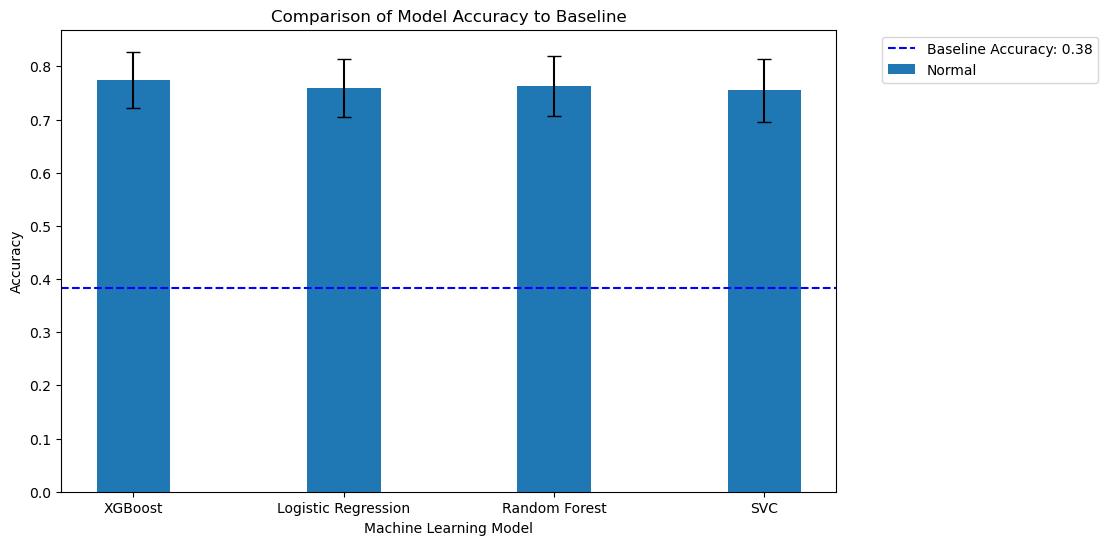

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

models = ['XGBoost','Logistic Regression','Random Forest', 'SVC']

normal_means = [acc_xgb_mean, acc_log2_mean, acc_rf_mean,acc_svc_mean]
normal_stds = [acc_xgb_std, acc_log2_std, acc_rf_std,acc_svc_std]

df = pd.DataFrame({
    'Model': models,
    'Accuracy Mean': normal_means,
    'Accuracy Std': normal_stds
})

plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Set the bar width
bar_width = 0.35

# Set the positions for the groups
positions = np.arange(len(models))

# Plot the bars
ax.bar(positions, df['Accuracy Mean'], width=bar_width, label='Normal', yerr=df['Accuracy Std'], capsize=5)

# Set the x-axis ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(models)

# Set labels and title
ax.set_xlabel('Machine Learning Model')
ax.set_ylabel('Accuracy')
plt.title('Comparison of Model Accuracy to Baseline')
plt.axhline(y=baseline_score, color='blue', linestyle='--', label='Baseline Accuracy: 0.38')
# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/NormalAccuCompare.png", dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrix

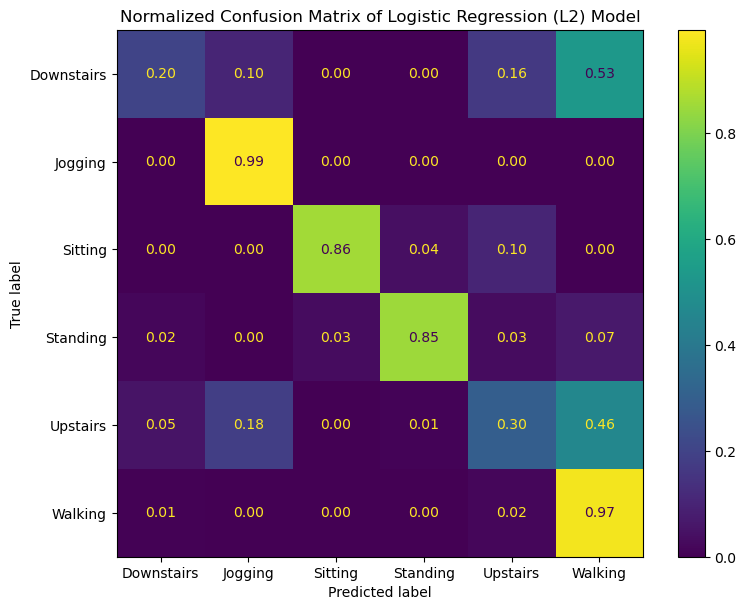

In [34]:
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Compute confusion matrix
cm_log2 = confusion_matrix(y_true_log2, y_pred_log2)

# Normalize confusion matrix
cm_log2_normalized = normalize(cm_log2, axis=1, norm='l1')  # Normalize along the rows (axis=1)

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log2_normalized, display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format=".2f")  # You can customize the format of the displayed values
plt.tight_layout()
plt.title('Normalized Confusion Matrix of Logistic Regression (L2) Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/L2NormalizedConfMatx.png", dpi=300, bbox_inches='tight')
plt.show()

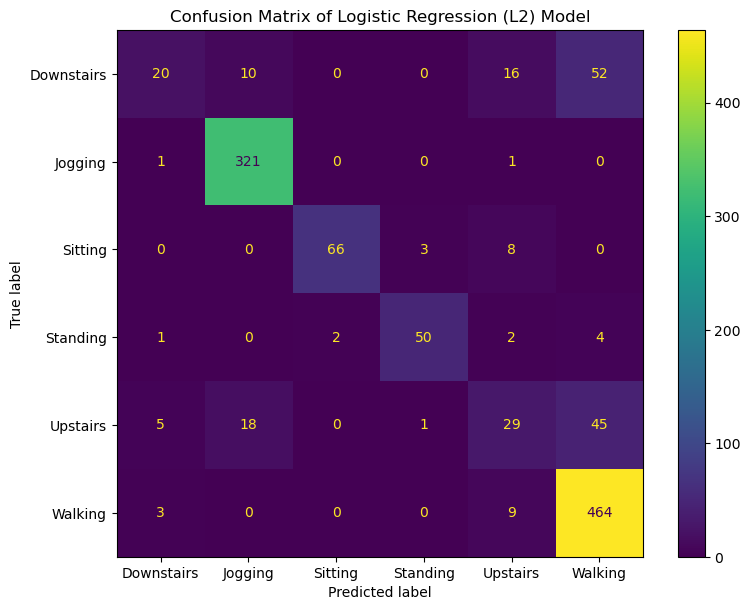

In [35]:
import matplotlib.pyplot as plt

# Log L2
cm_log2 = confusion_matrix(y_true_log2,y_pred_log2)
disp = ConfusionMatrixDisplay(cm_log2,display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax)
plt.tight_layout()
plt.title('Confusion Matrix of Logistic Regression (L2) Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/L2ConfMatx.png", dpi=300,bbox_inches='tight')
plt.show()

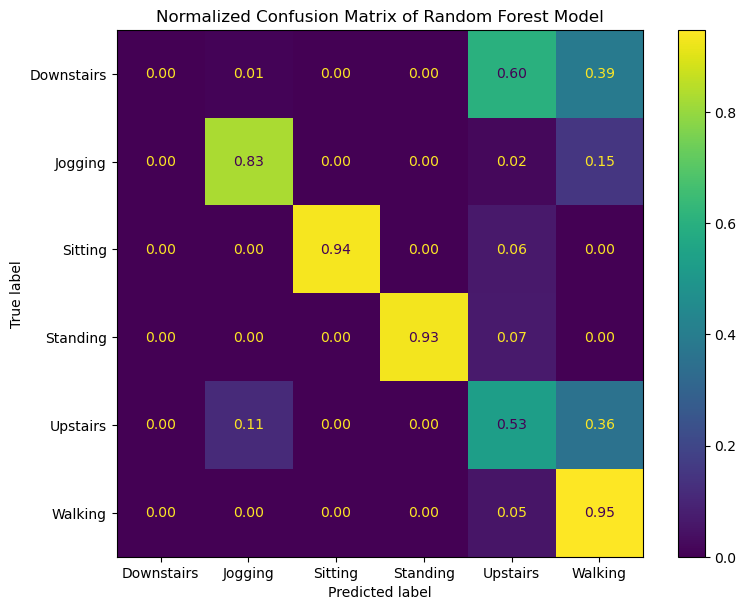

In [36]:
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)

# Normalize confusion matrix
cm_rf_normalized = normalize(cm_rf, axis=1, norm='l1')  # Normalize along the rows (axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_normalized, display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format=".2f")  # You can customize the format of the displayed values
plt.tight_layout()
plt.title('Normalized Confusion Matrix of Random Forest Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/RFNormalizedConfMatx.png", dpi=300, bbox_inches='tight')
plt.show()

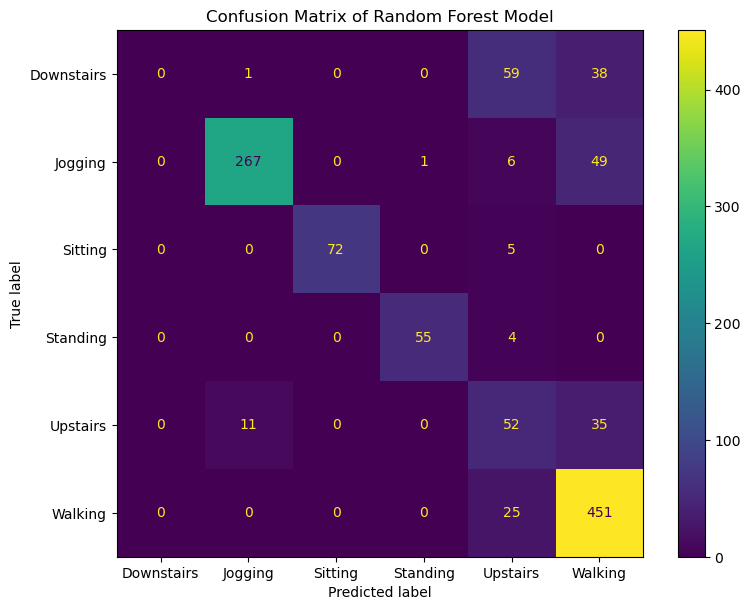

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Random Forest 
cm_rf = confusion_matrix(y_true_rf,y_pred_rf)
disp = ConfusionMatrixDisplay(cm_rf,display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax)
plt.tight_layout()
plt.title('Confusion Matrix of Random Forest Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/RFConfMatx.png", dpi=300,bbox_inches='tight')
plt.show()

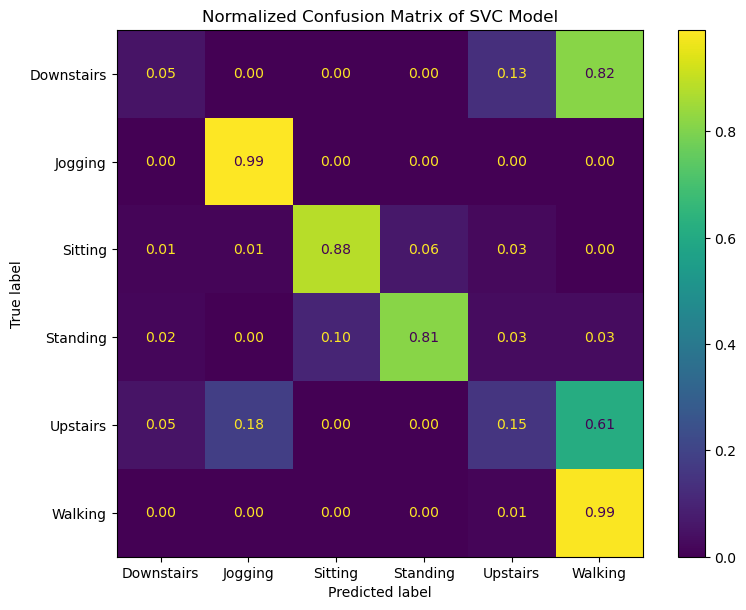

In [38]:
cm_svc = confusion_matrix(y_true_svc, y_pred_svc)

# Normalize confusion matrix
cm_svc_normalized = normalize(cm_svc, axis=1, norm='l1')  # Normalize along the rows (axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_normalized, display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format=".2f")  # You can customize the format of the displayed values
plt.tight_layout()
plt.title('Normalized Confusion Matrix of SVC Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/SVCNormalizedConfMatx.png", dpi=300, bbox_inches='tight')
plt.show()

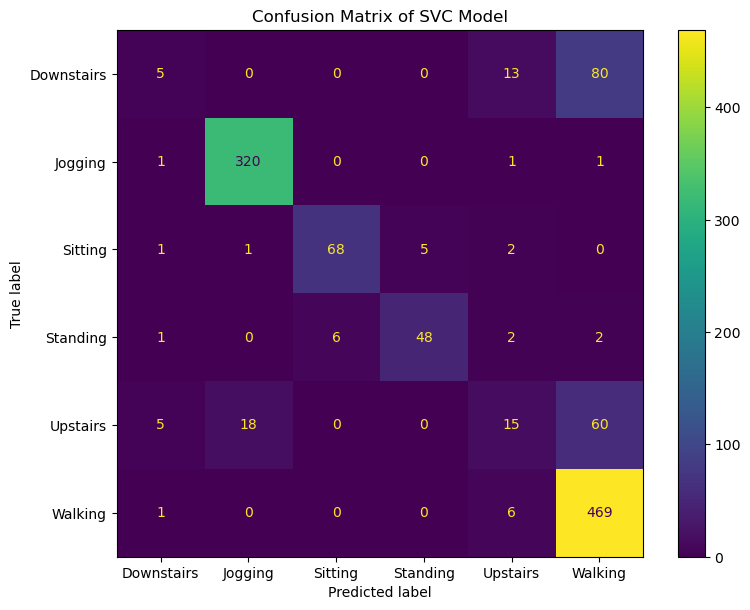

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# SVC
cm_svc = confusion_matrix(y_true_svc,y_pred_svc)
disp = ConfusionMatrixDisplay(cm_svc,display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax)
plt.tight_layout()
plt.title('Confusion Matrix of SVC Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/SVCConfMatx.png", dpi=300,bbox_inches='tight')
plt.show()

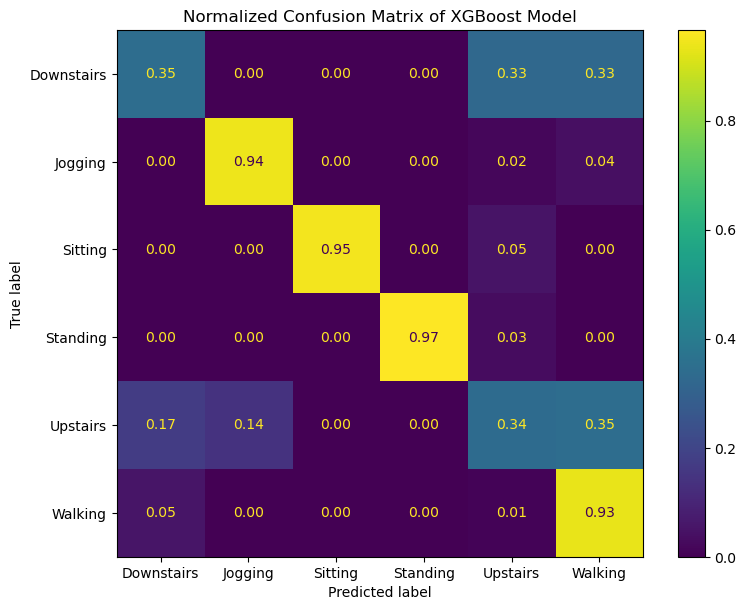

In [40]:
cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)

# Normalize confusion matrix
cm_xgb_normalized = normalize(cm_xgb, axis=1, norm='l1')  # Normalize along the rows (axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_normalized, display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format=".2f")  # You can customize the format of the displayed values
plt.tight_layout()
plt.title('Normalized Confusion Matrix of XGBoost Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/XGBNormalizedConfMatx.png", dpi=300, bbox_inches='tight')
plt.show()

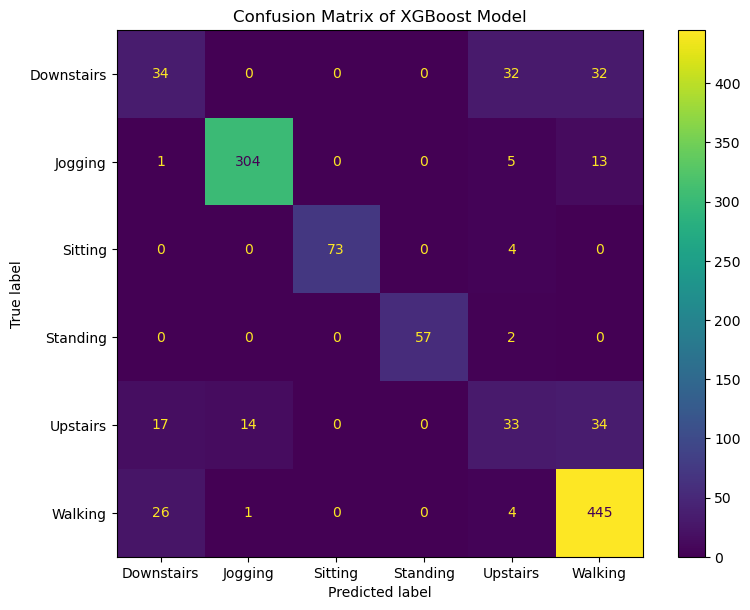

In [41]:
# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_true_xgb,y_pred_xgb)
disp = ConfusionMatrixDisplay(cm_xgb,display_labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax)
plt.tight_layout()
plt.title('Confusion Matrix of XGBoost Model')
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/XGBConfMatx.png", dpi=300,bbox_inches='tight')
plt.show()

## Accuracy of Activity Recognition

In [42]:
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [43]:
# Alternatively, you can use the classification_report
from sklearn.metrics import classification_report
print("\nSVC Classification Report:")
print(classification_report(y_true_svc, y_pred_svc, target_names=class_labels,zero_division=1))

print("\nRF Classification Report:")
print(classification_report(y_true_rf, y_pred_rf, target_names=class_labels,zero_division=1))

print("\nLog L2 Classification Report:")
print(classification_report(y_true_log2, y_pred_log2, target_names=class_labels,zero_division=1))

print("\nXGBoost Classification Report:")
print(classification_report(y_true_xgb, y_pred_xgb, target_names=class_labels,zero_division=1))


SVC Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.36      0.05      0.09        98
     Jogging       0.94      0.99      0.97       323
     Sitting       0.92      0.88      0.90        77
    Standing       0.91      0.81      0.86        59
    Upstairs       0.38      0.15      0.22        98
     Walking       0.77      0.99      0.86       476

    accuracy                           0.82      1131
   macro avg       0.71      0.65      0.65      1131
weighted avg       0.77      0.82      0.77      1131


RF Classification Report:
              precision    recall  f1-score   support

  Downstairs       1.00      0.00      0.00        98
     Jogging       0.96      0.83      0.89       323
     Sitting       1.00      0.94      0.97        77
    Standing       0.98      0.93      0.96        59
    Upstairs       0.34      0.53      0.42        98
     Walking       0.79      0.95      0.86       476

    accuracy          

In [44]:
# Calculate accuracy for each class RF
accuracy_per_class_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)

# Print accuracy for each class
for class_label, accuracy in zip(class_labels, accuracy_per_class_rf):
    print(f"Accuracy for class {class_label}: {accuracy}")

# Overall accuracy
baseline_accuracy_rf = accuracy_score(y_true_rf, y_pred_rf)
print(f"\nOverall Accuracy: {baseline_accuracy_rf}")

Accuracy for class Downstairs: 0.0
Accuracy for class Jogging: 0.826625386996904
Accuracy for class Sitting: 0.935064935064935
Accuracy for class Standing: 0.9322033898305084
Accuracy for class Upstairs: 0.5306122448979592
Accuracy for class Walking: 0.9474789915966386

Overall Accuracy: 0.7931034482758621


In [45]:
# Calculate accuracy for each class SVC
accuracy_per_class_svc = cm_svc.diagonal() / cm_svc.sum(axis=1)

# Print accuracy for each class
for class_label, accuracy in zip(class_labels, accuracy_per_class_svc):
    print(f"Accuracy for class {class_label}: {accuracy}")

# Overall accuracy
baseline_accuracy_svc = accuracy_score(y_true_svc, y_pred_svc)
print(f"\Overall Accuracy: {baseline_accuracy_svc}")

Accuracy for class Downstairs: 0.05102040816326531
Accuracy for class Jogging: 0.9907120743034056
Accuracy for class Sitting: 0.8831168831168831
Accuracy for class Standing: 0.8135593220338984
Accuracy for class Upstairs: 0.15306122448979592
Accuracy for class Walking: 0.9852941176470589
\Overall Accuracy: 0.8178603006189213


In [46]:
# Calculate accuracy for each class #Logistic Regression l2
accuracy_per_class_log2 = cm_log2.diagonal() / cm_log2.sum(axis=1)

# Print accuracy for each class
for class_label, accuracy in zip(class_labels, accuracy_per_class_log2):
    print(f"Accuracy for class {class_label}: {accuracy}")

# Overall accuracy
baseline_accuracy_log2 = accuracy_score(y_true_log2, y_pred_log2)
print(f"\nOverall Accuracy: {baseline_accuracy_log2}")

Accuracy for class Downstairs: 0.20408163265306123
Accuracy for class Jogging: 0.9938080495356038
Accuracy for class Sitting: 0.8571428571428571
Accuracy for class Standing: 0.847457627118644
Accuracy for class Upstairs: 0.29591836734693877
Accuracy for class Walking: 0.9747899159663865

Overall Accuracy: 0.8399646330680813


In [47]:
# Calculate accuracy for each class XGB
accuracy_per_class_xgb = cm_xgb.diagonal() / cm_xgb.sum(axis=1)

# Print accuracy for each class
for class_label, accuracy in zip(class_labels, accuracy_per_class_xgb):
    print(f"Accuracy for class {class_label}: {accuracy}")

# Overall accuracy
baseline_accuracy_xgb = accuracy_score(y_true_xgb, y_pred_xgb)
print(f"\nOverall Accuracy: {baseline_accuracy_rf}")

Accuracy for class Downstairs: 0.3469387755102041
Accuracy for class Jogging: 0.9411764705882353
Accuracy for class Sitting: 0.948051948051948
Accuracy for class Standing: 0.9661016949152542
Accuracy for class Upstairs: 0.336734693877551
Accuracy for class Walking: 0.9348739495798319

Overall Accuracy: 0.7931034482758621


## Feature Importance 

## Global Feature Importance 

In [48]:
from sklearn.inspection import permutation_importance
feature_importance_xgb = best_models_xgb[0].feature_importances_
feature_importance_rf = best_models_rf[0].feature_importances_
feature_names = X.columns

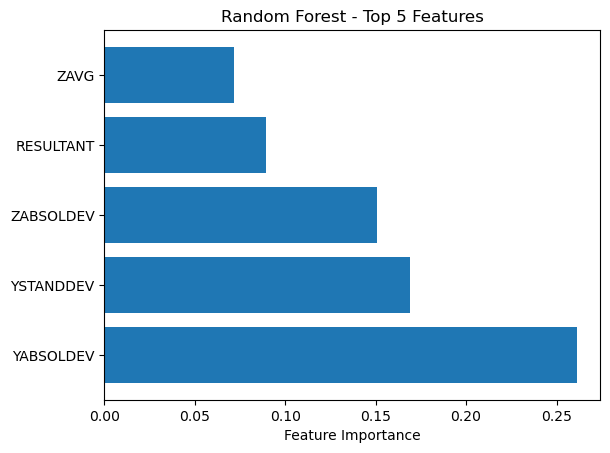

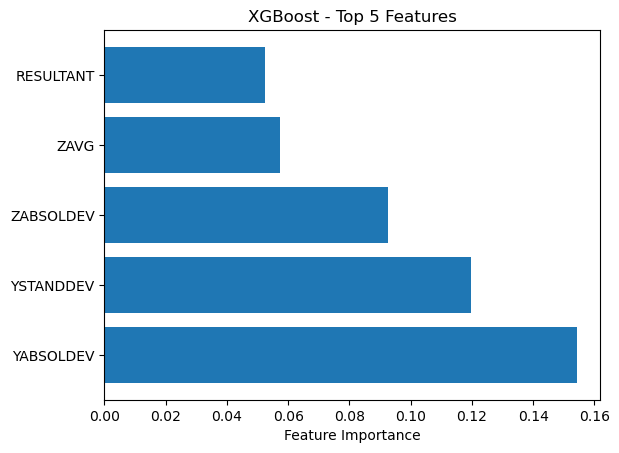

In [49]:
def plot_top_features(feature_importance, feature_names, model_name, top_n=5):
    sorted_idx = feature_importance.argsort()[::-1]
    top_idx = sorted_idx[:top_n]
    top_feature_names = [feature_names[i] for i in top_idx]
    top_feature_importance = feature_importance[top_idx]

    plt.barh(range(len(top_feature_importance)), top_feature_importance, align="center")
    plt.yticks(range(len(top_feature_importance)), top_feature_names)
    plt.xlabel("Feature Importance")
    plt.title(f"{model_name} - Top {top_n} Features")
    plt.savefig(f"/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/{model_name}imp.png", 
                dpi=300,bbox_inches='tight')
    plt.show()

# Assuming feature_names is a list containing the names of your features
plot_top_features(feature_importance_rf, feature_names, "Random Forest", top_n=5)
plt.show()
plot_top_features(feature_importance_xgb, feature_names, "XGBoost", top_n=5)
plt.show()

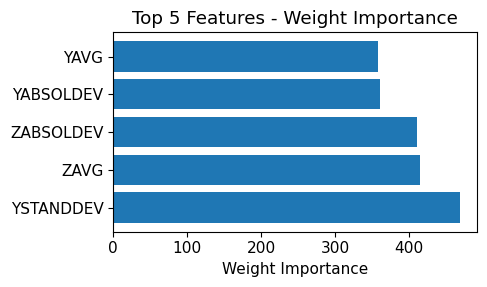

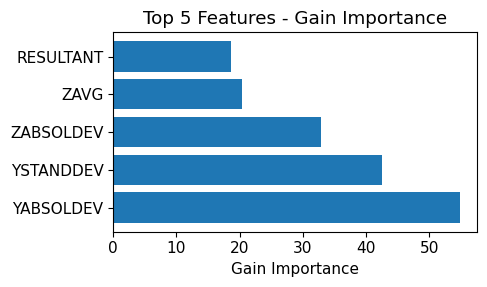

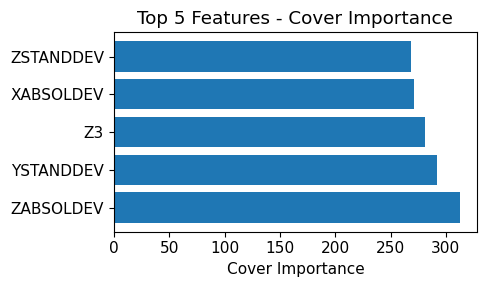

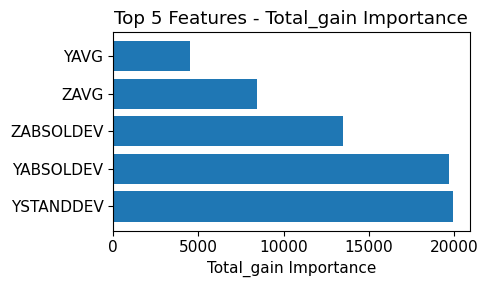

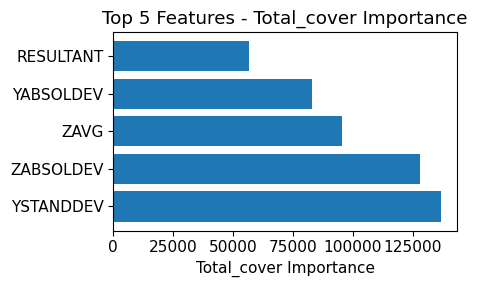

In [113]:
# your code here
model = best_models_xgb[0]
importance_type_list = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
feature_importances = {}

for importance_type in importance_type_list:
    importance_values = model.get_booster().get_score(importance_type=importance_type)
    feature_importances[importance_type] = importance_values

# Sort features based on importance for each metric
sorted_features = {importance_type: sorted(importance_values.items(), key=lambda x: x[1], reverse=True) for importance_type, importance_values in feature_importances.items()}

# Plot the top 5 features for each metric
plt.rcParams.update({'font.size': 11})

for importance_type, sorted_feature_list in sorted_features.items():
    top_n_features = 5
    
    plt.figure(figsize=(5,3))
    feature_names, importance_scores = zip(*sorted_feature_list[:top_n_features])
    
    plt.barh(range(top_n_features), importance_scores, align='center')
    plt.yticks(range(top_n_features), feature_names)
    plt.xlabel(importance_type.capitalize() + ' Importance')
    plt.title(f"Top {top_n_features} Features - {importance_type.capitalize()} Importance")
    plt.tight_layout()
    plt.savefig(f'/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/Top5_{importance_type.capitalize()}Importance.png', 
                dpi=300,bbox_inches='tight')
    plt.show()

## Shap Feature Importance

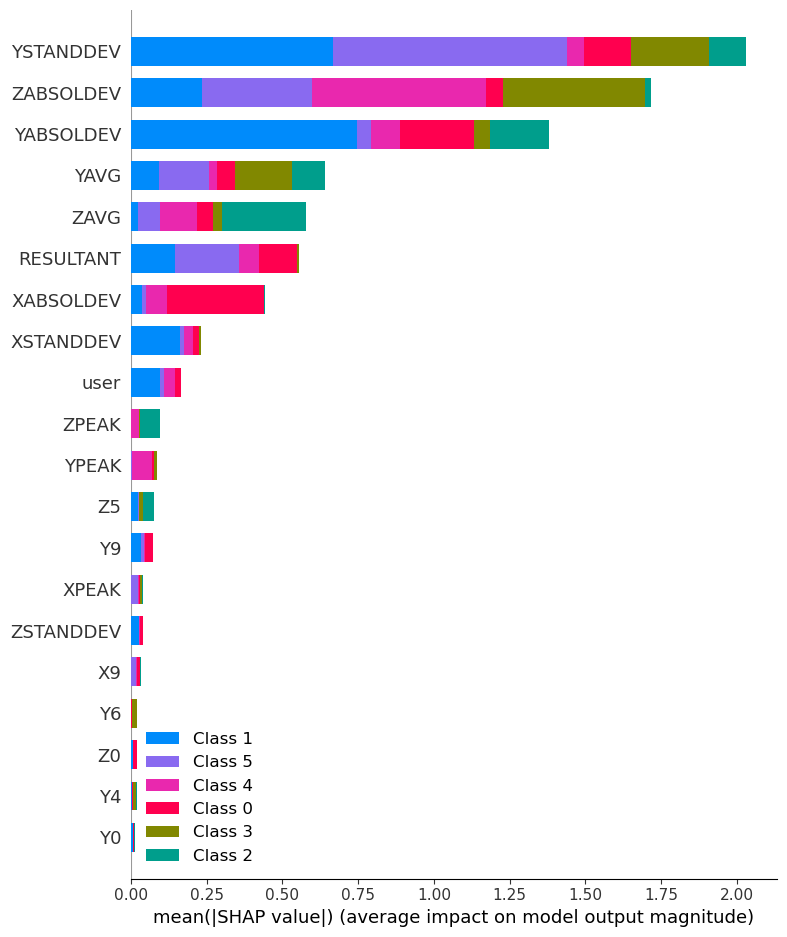

In [114]:
import shap
shap.initjs()
model_boost = importance_values = model.get_booster()
explainer = shap.TreeExplainer(model_boost)
df_test_xgb = xgb_dict['X Test']
shap_values = explainer.shap_values(df_test_xgb.values)

shap.summary_plot(shap_values, df_test_xgb, show=False)
plt.savefig("/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/shap_summary.png",dpi=300,bbox_inches='tight') 
plt.show()



0.17792478


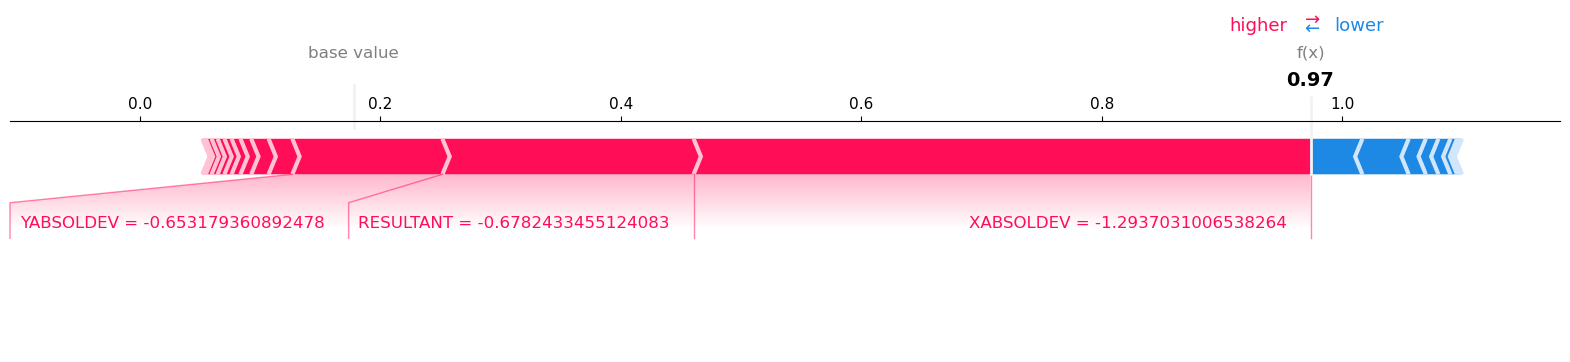

In [131]:
# Walking downstairs 0
index = 6 
print(explainer.expected_value[0]) 
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = df_test_xgb.iloc[index,:],feature_names = df_test_xgb.columns,matplotlib=True,show=False)
plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/DownstairsForcePlot.png', dpi=300,bbox_inches='tight')
plt.show()


1.06907


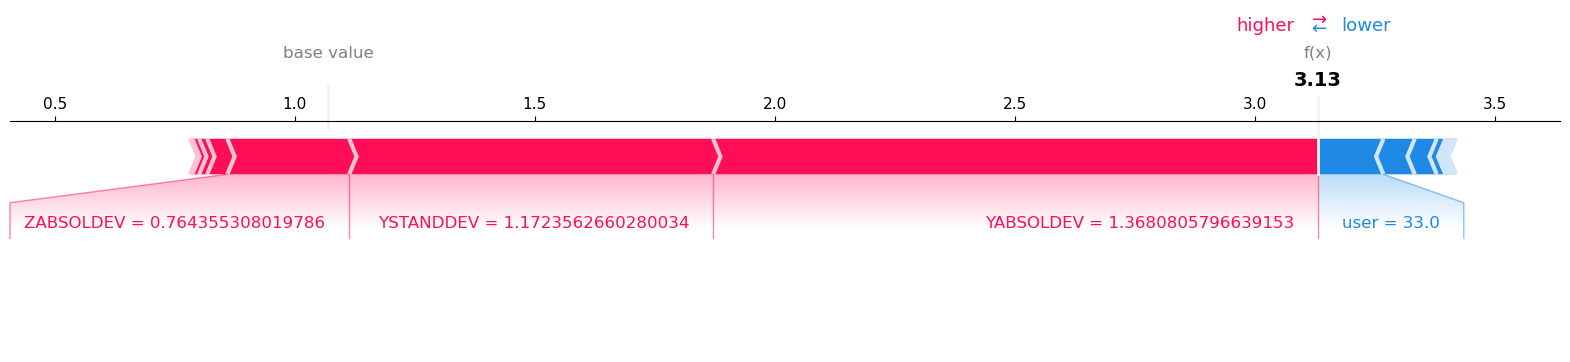

In [123]:
# Local Features 
#Jogging (1)
index = 0
print(explainer.expected_value[1]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = df_test_xgb.iloc[index,:],feature_names = df_test_xgb.columns,matplotlib=True,show=False)
plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/JoggingForcePlot.png',bbox_inches='tight',dpi=300)
plt.show()


-0.5137205


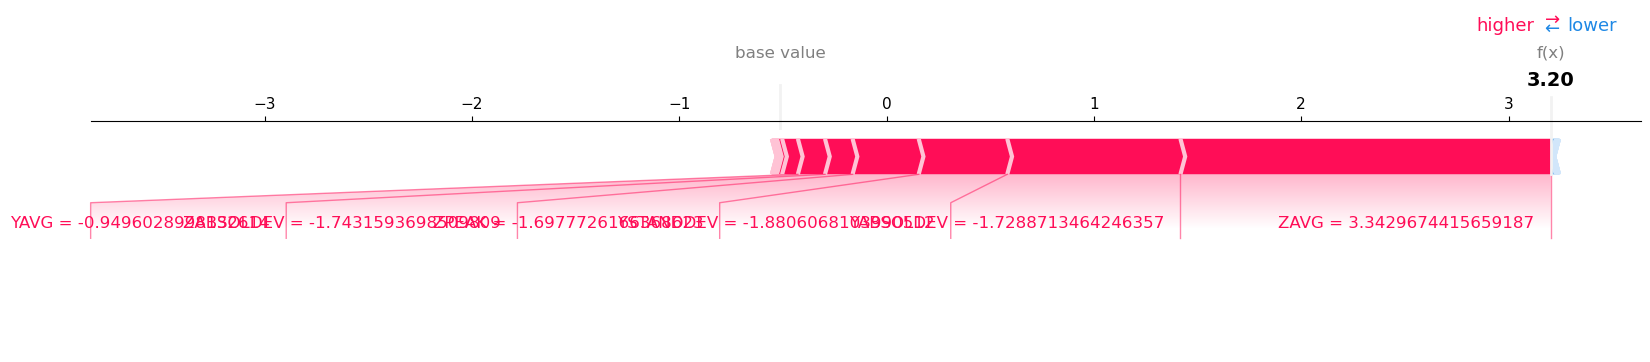

In [124]:
# Local Features 
#Sitting (2)
index = 589
print(explainer.expected_value[2]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[2], shap_values[2][index,:], features = df_test_xgb.iloc[index,:],feature_names = df_test_xgb.columns,matplotlib=True, show=False)
plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/SittingForcePlot.png',dpi=300,bbox_inches='tight')
plt.show()


-0.5534482


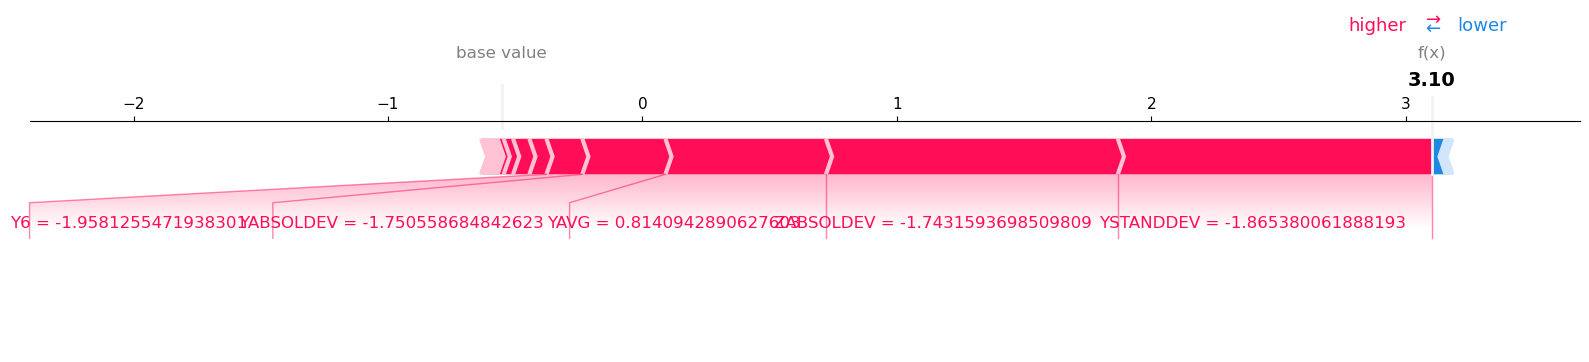

In [125]:
# Local Features 
#Standing (3)
index = 582 
print(explainer.expected_value[3]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[3], shap_values[3][index,:], features = df_test_xgb.iloc[index,:],feature_names = df_test_xgb.columns,matplotlib=True,show=False)
plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/StandingForcePlot.png',dpi=300,bbox_inches='tight')
plt.show()


0.31834033


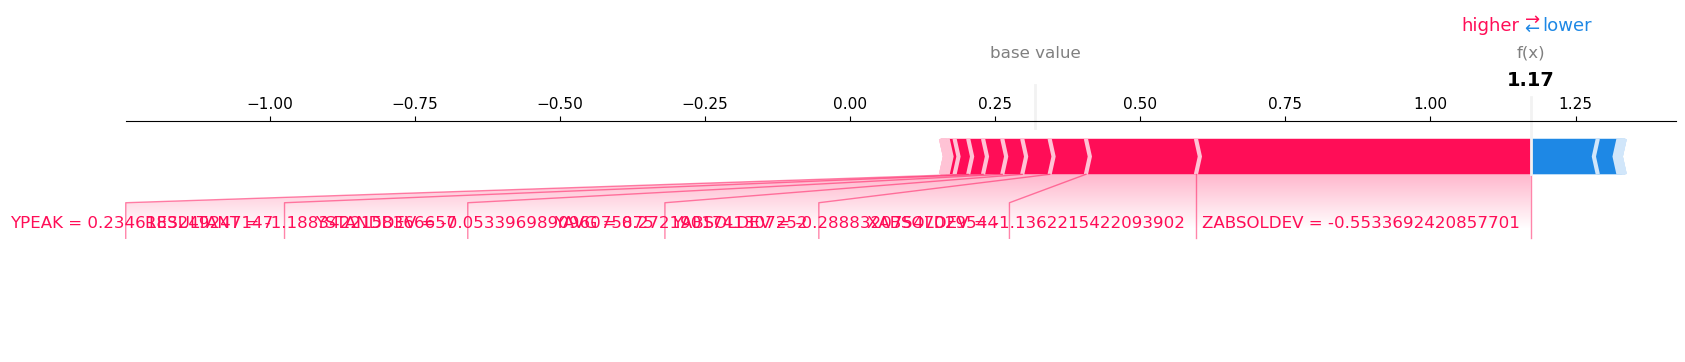

In [129]:
# Local Features 
#Upstairs (4)
index = 5
print(explainer.expected_value[4]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[4], shap_values[4][index,:], features = df_test_xgb.iloc[index,:],feature_names = df_test_xgb.columns, matplotlib=True,show=False)
plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/UpstairsForcePlot.png',dpi=300,bbox_inches='tight')
plt.show()


1.4451623


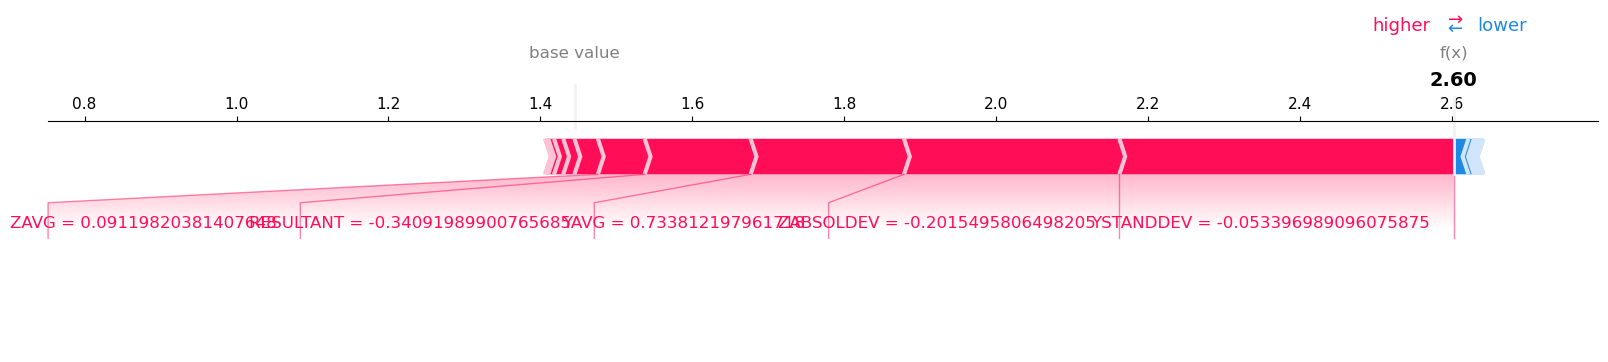

In [132]:
# Local Features 
# Walking (5)
index= 3
print(explainer.expected_value[5]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[5], shap_values[5][index,:], features = df_test_xgb.iloc[index,:],
                feature_names = df_test_xgb.columns,matplotlib=True, show=False)

plt.savefig('/Users/dominiquebarnes/Desktop/DATA1030_Fall2023/Project/FinalProject/figures/WalkingForcePlot.png',
            dpi=300,bbox_inches='tight')
plt.show()


